In [1]:
import pandas as pd

data = pd.read_csv("generated_dataset.csv")
data.head()

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202


In [2]:
data['leak_status']=data['CR-corrosion defect']
data = data.rename(columns = {'CR-corrosion defect':"CRD"}, inplace=False)

data['leak_status']=data['leak_status'].astype('object')

# classififying the data classes into 4 categories
data.loc[(data.CRD<0.150), 'leak_status']= 0
data.loc[(data.CRD>=0.150)&(data.CRD<0.200), 'leak_status']= 1
data.loc[(data.CRD>=0.200)&(data.CRD<0.250), 'leak_status']= 2
data.loc[(data.CRD>=0.250), 'leak_status']= 3
data = data.drop('CRD', axis=1)

data['leak_status']=data['leak_status'].astype('category')

# Create a binary 'leak' column
data['leak'] = data['leak_status'].apply(lambda x: 1 if x > 0 else 0)

data.head()

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,leak_status,leak
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,2,1
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,2,1
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,2,1
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,2,1
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,2,1


In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Summary statistics
summary_statistics = data.describe()
print("Summary statistics:\n", summary_statistics)


Missing values in each column:
 Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
leak_status                                0
leak                                       0
dtype: int64
Summary statistics:
        Wellhead Temp. (C)  Wellhead Press (psi)    MMCFD- gas  \
count        10292.000000          10292.000000  10292.000000   
mean            57.352401           1361.783583      8.851533   
std              9.423529            559.275420      4.968737   
min             41.070000            382.080000      0.230000   
25%             49.220000            880.000000      4.570000   
50%             57.360000           1364.900000      8.880000   
75%             65.412500    

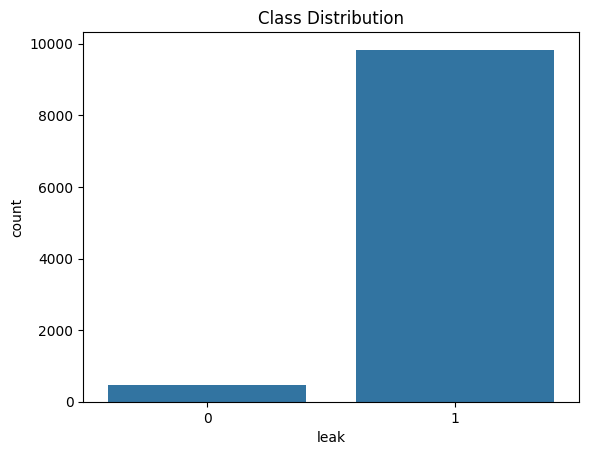

In [4]:
# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns


class_labels = ['No Leak', 'Leak']

sns.countplot(x='leak', data=data)
plt.title('Class Distribution')
plt.show()

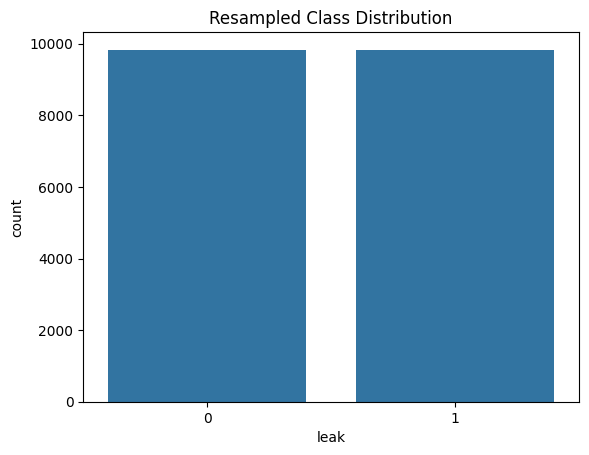

Leak Status
Leak       9832
No Leak    9832
Name: count, dtype: int64


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Split the dataset into features and target for binary classification
X = data.drop(columns=['leak_status', 'leak'])
y = data['leak']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize resampled class distribution
sns.countplot(x=y_resampled)
plt.title('Resampled Class Distribution')
plt.show()

y_resampled_series = pd.Series(y_resampled, name='Leak Status')

print(y_resampled_series.value_counts().rename(index={i: class_labels[i] for i in range(len(class_labels))}))

In [6]:
from sklearn.model_selection import train_test_split

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Further split the training set into training and validation sets (80-20 split of the training set)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [7]:
import numpy as np

# Reshape for LSTM input (samples, time steps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



In [11]:

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical


def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(1, X_train.shape[1])))
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=160, step=16), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.2, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=160, step=16)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01])),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='LSTM_Trials_1',
    project_name='pipeline_leak_severity'
)

# Perform the search
tuner.search(X_train_reshaped, y_train, epochs=15, validation_data=(X_val_reshaped, y_val), verbose=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best Parameters: {best_hps.values}')

Trial 10 Complete [00h 01m 27s]
val_accuracy: 0.9666348993778229

Best val_accuracy So Far: 0.9768033027648926
Total elapsed time: 00h 17m 51s
Best Parameters: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01}


In [12]:
# Build the model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the final model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = final_model.fit(
    X_train_reshaped, y_train, 
    validation_data=(X_val_reshaped, y_val), 
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)

val_loss, val_accuracy, val_auc = final_model.evaluate(X_val_reshaped, y_val)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)
print("Validation AUC: ", val_auc)

Epoch 1/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8370 - auc: 0.9147 - loss: 0.3576 - val_accuracy: 0.8891 - val_auc: 0.9628 - val_loss: 0.2481
Epoch 2/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8919 - auc: 0.9651 - loss: 0.2395 - val_accuracy: 0.9120 - val_auc: 0.9785 - val_loss: 0.1897
Epoch 3/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9240 - auc: 0.9789 - loss: 0.1876 - val_accuracy: 0.9336 - val_auc: 0.9825 - val_loss: 0.1722
Epoch 4/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9317 - auc: 0.9825 - loss: 0.1683 - val_accuracy: 0.9403 - val_auc: 0.9854 - val_loss: 0.1579
Epoch 5/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9346 - auc: 0.9845 - loss: 0.1566 - val_accuracy: 0.9546 - val_auc: 0.9902 - val_loss: 0.1272
Epoch 6/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9508 - auc: 0.9894 - loss: 0.1273 - val_accuracy: 0.9568 - val_auc: 0.9907 - val_loss: 0.1184
Epoch 7/50
787/787 ━━━━━━━━━━━━━━━━━━

In [14]:
# Save the trained model
final_model.save('lstm_leak_detection.keras')


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Validation Accuracy 2: 0.9780743565300286
Validation ROC-AUC Score: 0.9960733502376103
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1573
           1       0.99      0.97      0.98      1574

    accuracy                           0.98      3147
   macro avg       0.98      0.98      0.98      3147
weighted avg       0.98      0.98      0.98      3147



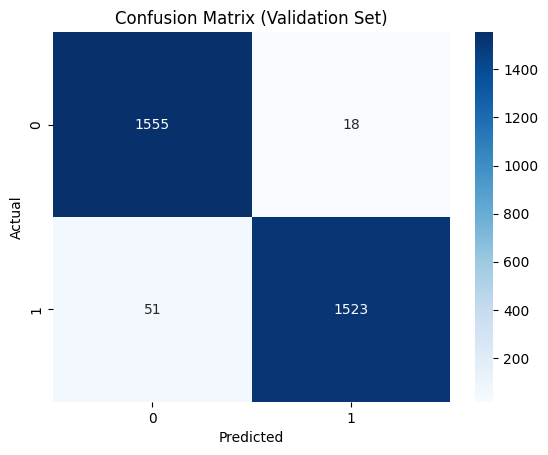

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the validation set
y_val_prob = final_model.predict(X_val_reshaped).flatten()

# Convert probabilities to class labels
y_val_pred = (y_val_prob > 0.5).astype(int)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy 2:", val_accuracy)

# ROC-AUC Score
val_roc_auc = roc_auc_score(y_val, y_val_prob)
print("Validation ROC-AUC Score:", val_roc_auc)

# Classification report
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

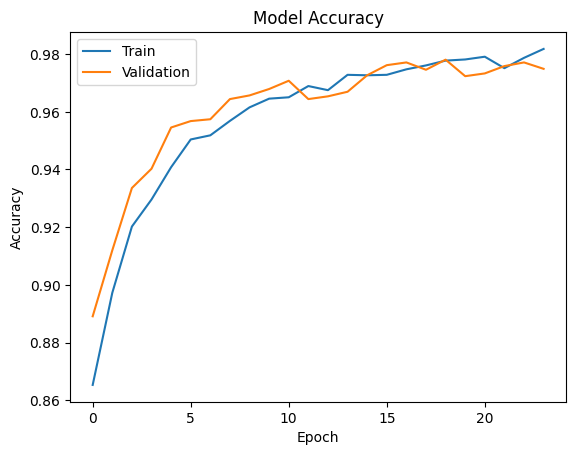

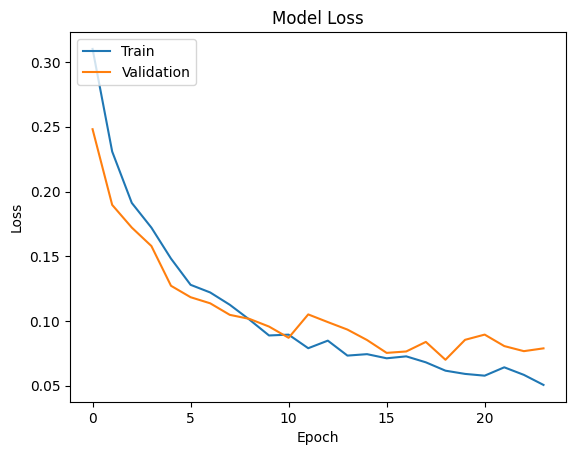

In [16]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9769 - auc: 0.9955 - loss: 0.0703
Test Loss:  0.07635251432657242
Test Accuracy:  0.9763539433479309
Test AUC:  0.9946539998054504
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1967
           1       0.99      0.97      0.98      1966

    accuracy                           0.98      3933
   macro avg       0.98      0.98      0.98      3933
weighted avg       0.98      0.98      0.98      3933



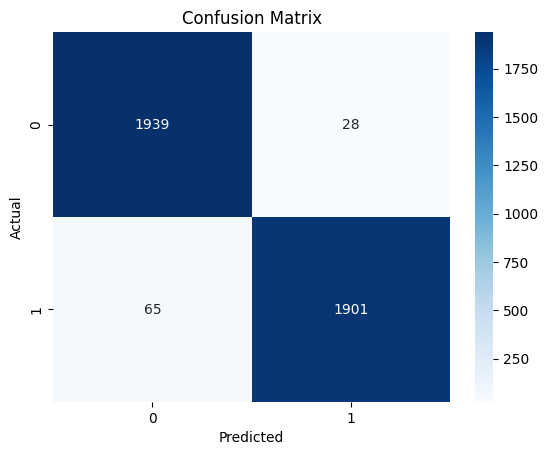

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = final_model.evaluate(X_test_reshaped, y_test)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test AUC: ", test_auc)

# Predict class probabilities
y_prob = final_model.predict(X_test_reshaped).flatten()

# Convert probabilities to class labels
y_pred = (y_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [19]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('lstm_leak_detection.keras')

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import numpy as np


# Example case scenario
example_case = {
    'Wellhead Temp. (C)': 50.0,
    'Wellhead Press (psi)': 1450.0,
    'MMCFD- gas': 9.0,
    'BOPD (barrel of oil produced per day)': 460.0,
    'BWPD (barrel of water produced per day)': 220.0,
    'BSW - basic solid and water (%)': 5.5,
    'CO2 mol. (%) @ 25 C & 1 Atm.': 1.1,
    'Gas Grav.': 0.67,
}
# Convert the example case to a DataFrame
example_df = pd.DataFrame([example_case])
example_scaled = scaler.fit_transform(example_df)

# Reshape the data to fit LSTM input
example_scaled_reshaped = example_scaled.reshape((1, 1, example_scaled.shape[1]))

# Predict using the model
example_prediction = loaded_model.predict(example_scaled_reshaped)
example_prediction_proba = example_prediction.flatten()

# Convert prediction to integer
example_prediction_int = int(example_prediction_proba[0] > 0.5)

predicted_leak_status_str = f"Predicted leak status: {class_labels[example_prediction_int]}"
prediction_probabilities_str = f"Prediction probability for 'Leak': {example_prediction_proba[0]:.2%}"

print(predicted_leak_status_str)
print(prediction_probabilities_str)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted leak status: Leak
Prediction probability for 'Leak': 99.96%
